## Part 2: Market Basket Analysis

Our aim for this part is to analyze products which are frequently purchased together and identify if there are strong association between products purchased from various orders using the Apriori Algorithm.

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', 150)
from scipy import sparse  # sparse matrices
import os

# import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For Association Rule Mining
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth, association_rules 

##Ignore Warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #Import Dataset files
# import pandas as pd
# df_orders = pd.read_csv('/content/drive/MyDrive/DATA240/Data/orders.csv')
# df_order_pd_prior = pd.read_csv('/content/drive/MyDrive/DATA240/Data/order_products__prior.csv')
# df_order_pd_train = pd.read_csv('/content/drive/MyDrive/DATA240/Data/order_products__train.csv')
# df_products = pd.read_csv('/content/drive/MyDrive/DATA240/Data/products.csv')

In [4]:
#Import Dataset files

df_orders = pd.read_csv('orders.csv')
df_order_pd_prior = pd.read_csv('order_products__prior.csv')
df_order_pd_train = pd.read_csv('order_products__train.csv')
df_products = pd.read_csv('products.csv')

In [5]:
#concatenating two Order Product files- train and prior 

df_order_products = pd.concat([df_order_pd_prior,df_order_pd_train],0)
df_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
#Display unique products in combined dataset
print('No. of unique products in Order Products Total' ,df_order_products['product_id'].nunique())

No. of unique products in Order Products Total 49685


##### For this section, only the product and order details are required from the df_order_products dataframe created above. 

##### We are considering only the top 75 frequently purchased products for this part. 

##### The data will be transposed and binarized, wherein each row will represent one order, and each column will represent a product with a flag of whether or not that was purchased in that order. 

In [7]:
df_product_counts = df_order_products.groupby('product_id')['order_id'].count().reset_index().rename(columns = {'order_id':'frequency'})
df_product_counts = df_product_counts.sort_values('frequency', ascending=False)[:75].reset_index(drop = True)
df_product_counts = df_product_counts.merge(df_products, on = 'product_id', how = 'left')
df_product_counts.head(5)


,product_id,frequency,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4


In [8]:

freq_products = list(df_product_counts.product_id)

df_order_products_freq = df_order_products[df_order_products['product_id'].isin(freq_products)]
df_order_products_freq.shape

(6844422, 4)

In [9]:
#Adding product name using df_products to the dataset with frequent order_products

df_order_products_freq = df_order_products_freq.merge(df_products, on = 'product_id', how='left')
df_order_products_freq.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,28985,2,1,Michigan Organic Kale,83,4
1,2,17794,6,1,Carrots,83,4
2,3,24838,2,1,Unsweetened Almondmilk,91,16
3,3,21903,4,1,Organic Baby Spinach,123,4
4,3,46667,6,1,Organic Ginger Root,83,4


In [10]:
# Transpose the dataset where columns=Product Name, and rows =order ID
df_basket = df_order_products_freq.groupby(['order_id', 'product_name'])['reordered'].count().unstack().reset_index().fillna(0).set_index('order_id')
df_basket.head()

product_name,100% Whole Wheat Bread,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Blueberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,Carrots,Cucumber Kirby,Extra Virgin Olive Oil,Fresh Cauliflower,Grated Parmesan,Green Bell Pepper,Half & Half,Hass Avocados,Honeycrisp Apple,Jalapeno Peppers,Large Alfresco Eggs,Large Lemon,Lime Sparkling Water,Limes,Michigan Organic Kale,Organic Avocado,Organic Baby Arugula,Organic Baby Carrots,Organic Baby Spinach,Organic Blackberries,Organic Blueberries,Organic Cilantro,Organic Cucumber,Organic D'Anjou Pears,Organic Fuji Apple,Organic Gala Apples,Organic Garlic,Organic Garnet Sweet Potato (Yam),Organic Ginger Root,Organic Granny Smith Apple,Organic Grape Tomatoes,Organic Half & Half,Organic Hass Avocado,Organic Italian Parsley Bunch,Organic Kiwi,Organic Lacinato (Dinosaur) Kale,Organic Large Extra Fancy Fuji Apple,Organic Lemon,Organic Navel Orange,Organic Peeled Whole Baby Carrots,Organic Raspberries,Organic Red Bell Pepper,Organic Red Onion,Organic Reduced Fat 2% Milk,Organic Small Bunch Celery,Organic Strawberries,Organic Tomato Cluster,Organic Unsweetened Almond Milk,Organic Whole Milk,Organic Whole String Cheese,Organic Yellow Onion,Organic Zucchini,Original Hummus,Raspberries,Red Onion,Red Peppers,Red Vine Tomato,Seedless Red Grapes,Small Hass Avocado,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsweetened Almondmilk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#adjusting the value for cell greater than 1, for each column

In [12]:

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
df_basket = df_basket.applymap(encode_units)


In [13]:
df_basket.head(5)

product_name,100% Whole Wheat Bread,Apple Honeycrisp Organic,Asparagus,Bag of Organic Bananas,Banana,Blueberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,Carrots,Cucumber Kirby,Extra Virgin Olive Oil,Fresh Cauliflower,Grated Parmesan,Green Bell Pepper,Half & Half,Hass Avocados,Honeycrisp Apple,Jalapeno Peppers,Large Alfresco Eggs,Large Lemon,Lime Sparkling Water,Limes,Michigan Organic Kale,Organic Avocado,Organic Baby Arugula,Organic Baby Carrots,Organic Baby Spinach,Organic Blackberries,Organic Blueberries,Organic Cilantro,Organic Cucumber,Organic D'Anjou Pears,Organic Fuji Apple,Organic Gala Apples,Organic Garlic,Organic Garnet Sweet Potato (Yam),Organic Ginger Root,Organic Granny Smith Apple,Organic Grape Tomatoes,Organic Half & Half,Organic Hass Avocado,Organic Italian Parsley Bunch,Organic Kiwi,Organic Lacinato (Dinosaur) Kale,Organic Large Extra Fancy Fuji Apple,Organic Lemon,Organic Navel Orange,Organic Peeled Whole Baby Carrots,Organic Raspberries,Organic Red Bell Pepper,Organic Red Onion,Organic Reduced Fat 2% Milk,Organic Small Bunch Celery,Organic Strawberries,Organic Tomato Cluster,Organic Unsweetened Almond Milk,Organic Whole Milk,Organic Whole String Cheese,Organic Yellow Onion,Organic Zucchini,Original Hummus,Raspberries,Red Onion,Red Peppers,Red Vine Tomato,Seedless Red Grapes,Small Hass Avocado,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Strawberries,Uncured Genoa Salami,Unsweetened Almondmilk,Yellow Onions
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Graph to show Products and their support count that is no. of times a particular product was ordered in given dataset

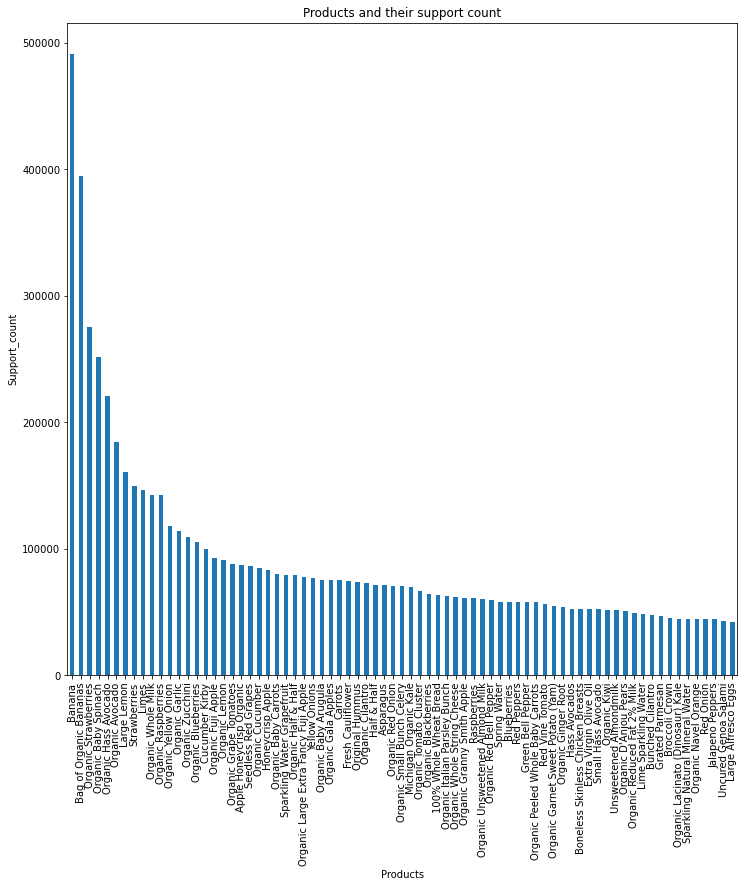

In [15]:
##bargraph

fig = plt.figure(figsize = (12, 12))
df_basket.sum(axis=0).sort_values(ascending=False).plot.bar( width=0.5)
plt.xlabel("Products")
plt.ylabel("Support_count")
plt.xticks(rotation = 90)
plt.title("Products and their support count")
plt.show()

#### Finding frequency based on support

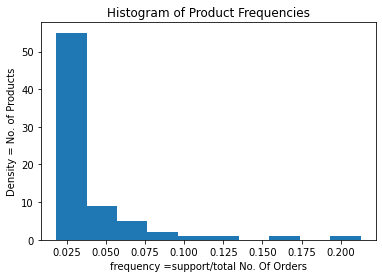

In [17]:
frequency = df_basket.sum(axis=0)/len(df_basket)
# creating the bar plot
plt.hist(frequency)
plt.xlabel("frequency =support/total No. Of Orders")
plt.ylabel("Density = No. of Products")
plt.title("Histogram of Product Frequencies")

plt.show()

#### Show 10 frequent Itemset based on minimum support as 1% using apiriori algorithm

In [18]:
frequent_itemsets = apriori(df_basket, min_support=0.01, use_colnames=True, low_memory=True)

In [19]:
top_10_freq_itemset=frequent_itemsets.sort_values(by='support', ascending=False)
top_10_freq_itemset

,support,itemsets
4,0.212592,(Banana)
3,0.170895,(Bag of Organic Bananas)
54,0.119248,(Organic Strawberries)
27,0.108918,(Organic Baby Spinach)
41,0.095578,(Organic Hass Avocado)
...,...,...
101,0.010405,"(Large Lemon, Organic Baby Spinach)"
76,0.010368,"(Bag of Organic Bananas, Organic Avocado)"
94,0.010295,"(Organic Raspberries, Banana)"
85,0.010244,"(Bag of Organic Bananas, Organic Zucchini)"


#### Determining association rule based on Confidence

In [20]:
confidence_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
final_results_confidence = confidence_rules.sort_values('confidence', ascending=False)

In [21]:
final_results_confidence

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(Organic Fuji Apple),(Banana),0.040195,0.212592,0.015211,0.378441,1.780125,0.006666,1.266827
2,(Honeycrisp Apple),(Banana),0.036054,0.212592,0.012825,0.355725,1.673272,0.005161,1.222161
1,(Cucumber Kirby),(Banana),0.043154,0.212592,0.014211,0.329296,1.548953,0.005036,1.174001
0,(Organic Large Extra Fancy Fuji Apple),(Bag of Organic Bananas),0.033777,0.170895,0.010531,0.311789,1.824449,0.004759,1.204725
3,(Organic Avocado),(Banana),0.079718,0.212592,0.024064,0.301866,1.419930,0.007117,1.127875


#### We can see that confidence Maximum confidence of association rule is 37%, it is suggested to check association rule based on Impact Factor/Lift

In [22]:
print(min(confidence_rules.confidence))
print(max(confidence_rules.confidence))

0.3018662063574779
0.3784409348792645


#### Determining association rule based on Lift/Impact factor with minimum threshold of 0.8

In [23]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.8)
final_results = rules.sort_values('lift', ascending=False)

In [24]:

print(max(rules.lift))

2.8417314949495838


In [25]:
final_results

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
42,(Limes),(Large Lemon),0.063463,0.069578,0.012548,0.197723,2.841731,0.008132,1.159726
43,(Large Lemon),(Limes),0.069578,0.063463,0.012548,0.180345,2.841731,0.008132,1.142599
63,(Organic Strawberries),(Organic Raspberries),0.119248,0.061707,0.015376,0.128940,2.089543,0.008017,1.077185
62,(Organic Raspberries),(Organic Strawberries),0.061707,0.119248,0.015376,0.249174,2.089543,0.008017,1.173044
45,(Large Lemon),(Organic Avocado),0.069578,0.079718,0.011150,0.160244,2.010145,0.005603,1.095893
...,...,...,...,...,...,...,...,...,...
26,(Limes),(Banana),0.063463,0.212592,0.014324,0.225713,1.061715,0.000833,1.016945
30,(Banana),(Organic Baby Spinach),0.212592,0.108918,0.023105,0.108683,0.997840,-0.000050,0.999736
31,(Organic Baby Spinach),(Banana),0.108918,0.212592,0.023105,0.212133,0.997840,-0.000050,0.999417
34,(Organic Strawberries),(Banana),0.119248,0.212592,0.025241,0.211665,0.995638,-0.000111,0.998824


In [26]:
#### Displaying top 25 association rules based on Lift

In [27]:
#After finding the rules with min_confidence, sort them based on lift in descending order and print the top 25 with their corresponding support, confidence, and lift.
rules.sort_values('lift',ascending=False).head(25)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
42,(Limes),(Large Lemon),0.063463,0.069578,0.012548,0.197723,2.841731,0.008132,1.159726
43,(Large Lemon),(Limes),0.069578,0.063463,0.012548,0.180345,2.841731,0.008132,1.142599
63,(Organic Strawberries),(Organic Raspberries),0.119248,0.061707,0.015376,0.128940,2.089543,0.008017,1.077185
62,(Organic Raspberries),(Organic Strawberries),0.061707,0.119248,0.015376,0.249174,2.089543,0.008017,1.173044
45,(Large Lemon),(Organic Avocado),0.069578,0.079718,0.011150,0.160244,2.010145,0.005603,1.095893
44,(Organic Avocado),(Large Lemon),0.079718,0.069578,0.011150,0.139862,2.010145,0.005603,1.081713
56,(Organic Strawberries),(Organic Blueberries),0.119248,0.045447,0.010829,0.090809,1.998138,0.005409,1.049893
57,(Organic Blueberries),(Organic Strawberries),0.045447,0.119248,0.010829,0.238274,1.998138,0.005409,1.156259
59,(Organic Hass Avocado),(Organic Raspberries),0.095578,0.061707,0.011602,0.121389,1.967167,0.005704,1.067927
58,(Organic Raspberries),(Organic Hass Avocado),0.061707,0.095578,0.011602,0.188018,1.967167,0.005704,1.113845


#### We see products that are usually bought together. Consider you plan to open a new store , we need to understand a superset of 
#### category in this case department which are closely associated to determine primary and supporting departments of our store

In [28]:
df_departments = pd.read_csv('departments.csv')

In [29]:
#Adding product name using df_products to the dataset with frequent order_products

df_order_products_freq = df_order_products_freq.merge(df_departments, on = 'department_id', how='left')
df_order_products_freq.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2,28985,2,1,Michigan Organic Kale,83,4,produce
1,2,17794,6,1,Carrots,83,4,produce
2,3,24838,2,1,Unsweetened Almondmilk,91,16,dairy eggs
3,3,21903,4,1,Organic Baby Spinach,123,4,produce
4,3,46667,6,1,Organic Ginger Root,83,4,produce


In [30]:
# Transpose the dataset where columns=Product Name, and rows =order ID
df_basket_dept = df_order_products_freq.groupby(['order_id', 'department'])['reordered'].count().unstack().reset_index().fillna(0).set_index('order_id')
df_basket_dept.head()

department,bakery,beverages,dairy eggs,deli,frozen,meat seafood,pantry,produce
order_id,,,,,,,,
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1 
    
df_basket_dept = df_basket_dept.applymap(encode_units)

In [32]:
frequent_itemsets_dept = apriori(df_basket_dept, min_support=0.01, use_colnames=True, low_memory=True)
frequent_itemsets_dept.head()

,support,itemsets
0,0.027311,(bakery)
1,0.091795,(beverages)
2,0.227667,(dairy eggs)
3,0.049644,(deli)
4,0.025214,(frozen)


In [33]:
rules_dept = association_rules(frequent_itemsets_dept, metric="lift", min_threshold=1)
final_results_dept = rules_dept.sort_values('lift', ascending=False)

In [34]:
final_results_dept

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,"(produce, dairy eggs)",(deli),0.182037,0.049644,0.013906,0.076393,1.538819,0.004869,1.028962
6,(deli),"(produce, dairy eggs)",0.049644,0.182037,0.013906,0.280122,1.538819,0.004869,1.136252
4,"(produce, deli)",(dairy eggs),0.042310,0.227667,0.013906,0.328680,1.443689,0.004274,1.150469
7,(dairy eggs),"(produce, deli)",0.227667,0.042310,0.013906,0.061082,1.443689,0.004274,1.019994
1,(dairy eggs),(deli),0.227667,0.049644,0.015333,0.067347,1.356596,0.004030,1.018981
0,(deli),(dairy eggs),0.049644,0.227667,0.015333,0.308852,1.356596,0.004030,1.117464
2,"(beverages, produce)",(dairy eggs),0.063979,0.227667,0.016673,0.260605,1.144679,0.002107,1.044548
3,(dairy eggs),"(beverages, produce)",0.227667,0.063979,0.016673,0.073235,1.144679,0.002107,1.009988


#### Recommendation based on association rules determined on products to add items in a particular purchase basket

###### Reference : https://www.kaggle.com/code/nishantgaurav23/market-basket-analysis-apriori-algorithm 

In [35]:
small_train = df_order_pd_train[['order_id', 'product_id']]
small_train_split = (small_train[:461543], small_train[461543:461543*2-1], small_train[461543*2-1:])

In [36]:
pivots = []
for df in small_train_split:
    pvt = ~(df.pivot(index='order_id', columns='product_id', values='product_id').isna())
    pivots.append(pvt.astype(pd.SparseDtype(bool)))
del pvt

product_cols = sorted(small_train.product_id.unique())

In [37]:
for i in range(len(pivots)):
    # reindexing to add extra columns and standardize the format for vstack
    # we sparse them again here b/c otherwise we would end up having regular boolean columns
    pivots[i] = pivots[i].reindex(columns=product_cols, fill_value=False).astype(pd.SparseDtype(bool))
    pivots[i] = sparse.csr_matrix(pivots[i])
# concat vertically
pivots = sparse.vstack(pivots)

In [38]:
# re-map and densify for algos
truth_table = pd.DataFrame(pivots.todense(), index=small_train.order_id.unique(), columns=product_cols)

In [39]:
# takes less than a minute to execute
frequent_itemsets = fpgrowth(truth_table, min_support=5/len(truth_table), use_colnames=True)

In [40]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)

In [41]:
# selecting out rules that might potentially not be enhancing
rules = rules[rules.lift > 1]

In [42]:
# a simplification of the table
rules_ante_cons = rules[['antecedents', 'consequents']]

In [43]:
# creating customers' baskets
baskets_rec = small_train.groupby('order_id')['product_id'].apply(frozenset)
baskets_rec.name = "basket"  # antecedents

In [44]:
train_orders=df_orders[df_orders.eval_set == 'train']

In [45]:
recommendations = train_orders.join(baskets_rec, on="order_id")
recommendations["recommendations"] = [frozenset() for _ in range(len(recommendations))]

In [46]:
# computationally-intensive; might require an optimization
for idx, antecedent in enumerate(rules_ante_cons["antecedents"]):
    lookup = antecedent <= recommendations.basket, "recommendations"
    recommendations.loc[lookup] = recommendations.loc[lookup].apply(
        frozenset.union,
        args=(rules_ante_cons.loc[idx, "consequents"],)
    )
# recommendations = recommendations.rename(columns={"antecedents": "basket"})
# this may be changed earlier
recommendations.loc[:, "recommendations"] = recommendations.recommendations - recommendations.basket

In [47]:
# non-empty recommendations
non_empty_recs = recommendations[recommendations.recommendations.apply(bool)]
print("1 out of approx.", round(1/(len(non_empty_recs) / len(recommendations))), "transactions will result in a recommendation being suggested to a customer.")
# mapping codes to product names
def map_products(codes):
    if isinstance(codes, pd.Series):
        return codes.apply(map_products)
    return frozenset(map(products.get, codes))

products = df_products
products = products.set_index("product_id")["product_name"].to_dict()
non_empty_recs.loc[:, ["basket", "recommendations"]] = non_empty_recs[["basket", "recommendations"]].apply(map_products)

1 out of approx. 14 transactions will result in a recommendation being suggested to a customer.
       product_id                                       product_name  \
0               1                         Chocolate Sandwich Cookies   
1               2                                   All-Seasons Salt   
2               3               Robust Golden Unsweetened Oolong Tea   
3               4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4               5                          Green Chile Anytime Sauce   
...           ...                                                ...   
49683       49684          Vodka, Triple Distilled, Twist of Vanilla   
49684       49685                 En Croute Roast Hazelnut Cranberry   
49685       49686                                   Artisan Baguette   
49686       49687         Smartblend Healthy Metabolism Dry Cat Food   
49687       49688                             Fresh Foaming Cleanser   

       aisle_id  department_id  
0     

In [48]:
def mba_diagram(sample_basket, sample_recommendation):
    import matplotlib.pyplot as plt

    def get_text_box_coords(txt):
        we = plt.Text.get_window_extent(txt, renderer=fig.canvas.get_renderer())
        return ax.transAxes.inverted().transform(we)
    def get_rightmost_vmid(box):
        return box[1][0], (box[0][1] + box[1][1]) / 2

    fig, ax = plt.subplots(figsize=(20,10))
    title = ax.set_title("An illustration of a recommendation system for a sample customer basket\n(basket ← suggestion)", fontsize=18)
    ax.axis('off')
    basket_txt = ax.text(.05, .95, sample_basket, ha='left', va='top', wrap=True,size=12,
                  bbox=dict(boxstyle='round,pad=1', fc='w', ec='lightblue'))

    basket_rightmost, basket_vmid = get_rightmost_vmid(get_text_box_coords(basket_txt))

    arrow_txt = ax.text(
        basket_rightmost*1.4, basket_vmid, "Add", ha="center", va="center", size=35,
        bbox=dict(boxstyle="larrow,pad=0.6", fc="lightgreen", ec="g", lw=2))
    arrow_rightmost, arrow_vmid = get_rightmost_vmid(get_text_box_coords(arrow_txt))

    recommendation_txt = ax.text(arrow_rightmost * 1.14, arrow_vmid, sample_recommendation, ha='left', va='top', wrap=True, fontsize=25,
                  bbox=dict(boxstyle='round,pad=1', fc='w', ec='r'))
    recommendation_txt_pos = recommendation_txt.get_position()
    recommendation_txt.set_position((
        recommendation_txt_pos[0],
        recommendation_txt_pos[1] + (get_text_box_coords(recommendation_txt)[1][1]-get_text_box_coords(recommendation_txt)[0][1]) / 2
    ))

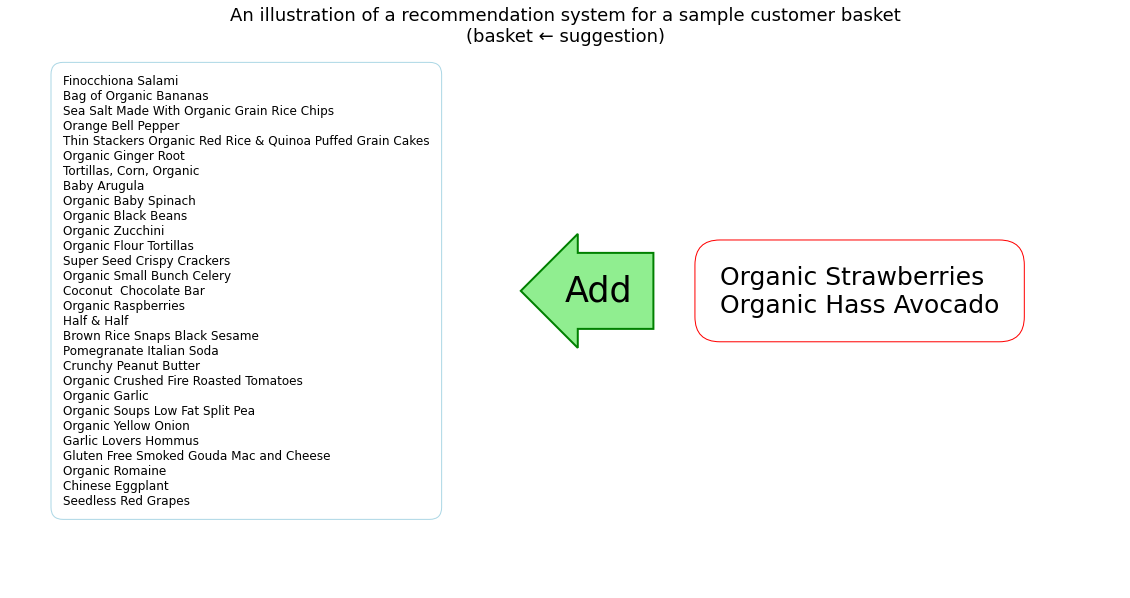

In [49]:
sample_index = np.random.randint(len(non_empty_recs))
sample_basket = "\n".join(non_empty_recs.iloc[sample_index].loc["basket"])
sample_recommendation = "\n".join(non_empty_recs.iloc[sample_index].loc["recommendations"])
mba_diagram(sample_basket, sample_recommendation)